In [3]:
import os
import re
import csv
import string
import pandas as pd
import numpy as np
import statistics
import itertools
from PIL import Image
import time
from io import StringIO
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda, Resize, Compose, ToPILImage, Normalize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [5]:
#print(os.listdir('/content/gdrive/MyDrive/COMP5329/'))  # Adjust path as necessary


In [6]:
np.random.seed(0)
# Load datasets
#TRAIN_CSV = ("/content/gdrive/MyDrive/COMP5329/train.csv")
#TEST_CSV = ("/content/gdrive/MyDrive/COMP5329/test.csv")
#IMAGES_DIR = ("/content/gdrive/MyDrive/COMP5329/data")

DIR = '/Users/sanaali/Downloads/COMP5329S1A2Dataset 2'

TRAIN_CSV = os.path.join(DIR, "train.csv")
TEST_CSV = os.path.join(DIR, "test.csv")
IMAGES_DIR = os.path.join(DIR, "data")

In [7]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda
from skimage import io
from io import StringIO

class AssignmentDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, target_transform=None, has_labels=True):
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        self.has_labels = has_labels

        with open(csv_file) as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.dataframe = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')])
        if not os.path.exists(img_path):
            print(f"Warning: File does not exist {img_path}")
            return None

        img = io.imread(img_path)

        img_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('ImageID')]
        caption = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Caption')]

        if self.has_labels:
            labels = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('Labels')]
            labels = labels.split(' ')
            labels = [int(x) for x in labels]

            if self.target_transform:
                labels = self.target_transform(labels)
            if self.transform:
                img = self.transform(img)

            sample = (img, labels, img_id, caption)
        else:
            if self.transform:
                img = self.transform(img)
            sample = (img, img_id, caption)

        return sample


In [8]:
def image_stats(checking_dataloader):
  '''
  A function to calculate the channel means and standard deviations of the image input in a training dataset.
  Sums the channel means & squared means per image, then calculates the overall mean and standard deviation by taking the first moment (mean) and square root of the second moment (variance).

  Parameters:
  checking_dataloader (torch.utils.data.Dataloader): The Dataloader object with a batch size of 1 and containing images, image labels, image IDs and captions.

  Returns:
    means (torch.Tensor): A tensor object containing the channel means as floats.
    stdevs (torch.Tensor): A tensor object containing the channel standard deviations as floats.
  '''

  sum_channels, sumsq_channels, n_batches = 0, 0, 0

  for step, (x, _, _, _ ) in enumerate(checking_dataloader):
    sum_channels += torch.mean(x, dim = [0, 2, 3])
    sumsq_channels += torch.mean(x**2 , dim = [0, 2, 3])
    n_batches += 1

  means = sum_channels/n_batches
  stdevs = (sumsq_channels/n_batches - means**2)**0.5

  return means, stdevs

In [9]:
##Finding Mean/std
NUM_LABELS = 19
BATCH_SIZE = 1

transforms = Compose([
    ToTensor(),
])

train_dataset_check = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                  has_labels = True,
                                 )

In [10]:
train_dataloader = DataLoader(train_dataset_check, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
means, stdevs = image_stats(train_dataloader)
print(f'Mean is: {means} \n Standard Deviation is: {stdevs}')


Mean is: tensor([0.4638, 0.4490, 0.4222]) 
 Standard Deviation is: tensor([0.2725, 0.2698, 0.2849])


In [12]:
def get_image_sizes(checking_dataloader):
    '''
    Obtains the heights and widths of the images within the supplied dataset.

    Parameters:
    checking_dataloader (torch.utils.data.Dataloader): The Dataloader object with a batch size of 1 and containing images, image labels, image IDs and captions.

    Returns:
      heights (list(int)): A list of the image heights as integers.
      widths (list(int)): A list of the image widths as integers.
    '''

    heights, widths = [], []

    for step, (img, _, _, _) in enumerate(checking_dataloader):
        heights.append(img.size()[2])
        widths.append(img.size()[3])

    return heights, widths

In [14]:
heights, widths = get_image_sizes(train_dataloader)

print(f'Median height is: {statistics.median(heights)}')
print(f'Mean height is: {statistics.mean(heights)}')
print(f'Median width is: {statistics.median(widths)}')
print(f'Mean width is: {statistics.mean(widths)}')

Median height is: 240.0
Mean height is: 240.5502066942259
Median width is: 320.0
Mean width is: 289.9553940525403


In [16]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 50
RESIZE_SIZE = (299, 299)
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.75
SEED = 5329

transforms = Compose([
    ToTensor(),
    Normalize(mean = means, std = stdevs),
    Resize(RESIZE_SIZE),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomCrop(CROP_SIZE)
])

# The main dataset available with labels
main_dataset = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                 has_labels = True
                                 )

# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = AssignmentDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transforms,
                                  has_labels = False)

main_dataloader = DataLoader(main_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [17]:
def encode_outputs(output, threshold):
  '''
  A function to transform sigmoid outputs to one-hot encoded representations, based on a threshold value which deems the sigmoid output to be positive.
  Creates a numpy array filled with zeros per observation, transforms this to a list and appends an index with 1s if the sigmoid output of the index is greater than the threshold then appends this observation to the encoded_outputs list containing all observations.

  Parameters:
  output (torch.Tensor): A torch tensor of model output/predictions, calculated on a dataset with a batch size of 1.
  threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

  Returns:
  encoded_outputs (list(list(int))): A list per observation containing a list of one-hot encoded predictions as integers with length 19.
  '''

  encoded_outputs = []
  for i in range(len(output)):
    encoded_output = np.zeros(19).tolist()
    for j in range(len(output[i][0])):
      encoded_output[j] = 1 if output[i][0][j].item() >= threshold else 0
    encoded_outputs.append(encoded_output)
  return encoded_outputs

def decode_labels(labels, threshold):
  '''
  A function to transform sigmoid outputs or OHE predictions to a list of numeric labels.
  Creates an empty list for an individual observation, appends with the value of the index + 1 which has the prediction greater than the threshold and aggregates in the decoded_labels list for all observations.

  Parameters:
  labels (list(torch.Tensor)): A list per observation of the one-hot encoded labels in a torch.Tensor.
  threshold (float): The desired probability threshold to consider a sigmoid output as a positive classification.

  Returns:
  decoded_labels (list(list(str))): A list for each observation containing a list of the labels as strings.
  '''

  decoded_labels = []
  for i in range(len(labels)):
    decoded_label = []
    for j in range(len(labels[i][0])):
      if labels[i][0][j].item() >= threshold:
        decoded_label.append(j + 1)
    decoded_labels.append(decoded_label)
  return decoded_labels

In [18]:
def show_img(dataset):
  '''
  A function to show a 2 x 3 plot of 6 random images and display the one-hot encoded labels above it.

  Parameters:
  dataset (AssignmentDataset): The dataset containing the desired set of images for which samples are to be plotted.

  Returns:
  None
  '''

  loader = DataLoader(train_dataset, batch_size = 6, shuffle = True)
  batch = next(iter(loader))
  images, labels,_,_ = batch

  grid = torchvision.utils.make_grid(images, nrow = 3)
  plt.figure(figsize = (12, 12))
  plt.imshow(np.transpose(grid, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


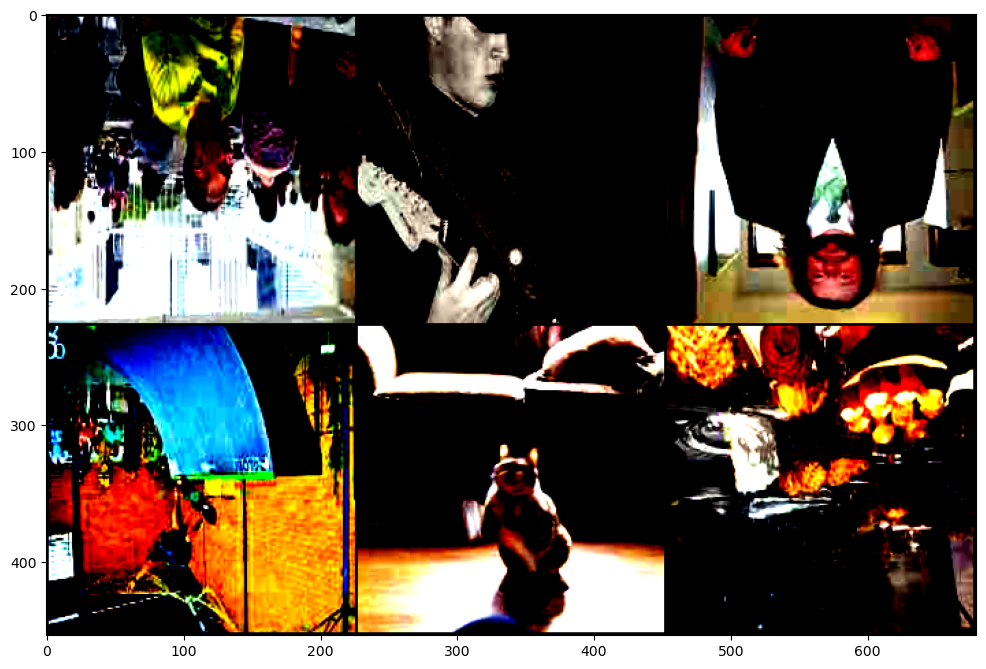

In [19]:
show_img(train_dataloader)

In [20]:
def train_loop(dataloader, val_dataloader, model, loss_fn, optimizer, test_threshold=None, with_captions=False):
    '''
    The function to run a training loop on a selected model and returns training losses per batch as well as validation loss & validation f1 if applicable.

    Sets the model to train model, iterates through the dataloader and passes the data forward through the network then calculates loss. Removes accumulated gradients in the optimizer and runs the backpropagation process, finally updating the parameters.
    Prints training updates as well as validation scores based on the test_threshold value.

    Parameters:
    dataloader (torch.utils.data.Dataloader): The dataloader object for the training data.
    val_dataloader(torch.utils.data.Dataloader): The dataloader object for the validation data.
    Model (child of torch.nn.Module): The chosen Model to train.
    loss_fn: The chosen loss function for learning & evaluation.
    optimizer: The chosen optimizer for parameter updates.
    test_threshold (float or None): The threshold on which to convert sigmoid outputs to positive labels in validation, or None to ensure validation is not conducted in training. Set to None by default.
    with_captions (bool): The boolean value indicating whether image captions are to incorporated into the model.

    Returns:
      train_batch_losses (list): A list of the loss values per training batch.
      val_batch_losses (list): A list of the loss values per validation epoch.
      val_f1_scores (list): A list of the mean F1 scores per validation epoch.
    '''

    train_batch_losses = []
    val_batch_losses = []
    val_f1_scores = []

    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()

    for batch, (X, y, _, captions) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        if with_captions:
            # Perform encoding for the captions
            word_encoding_array = encode_captions(captions)
            # Compute prediction and loss
            pred = model(X, word_encoding_array)
        else:
            pred = model(X)

        if type(model) == torchvision.models.inception.Inception3:
          loss = loss_fn(pred.logits, y.type(torch.float))
        else:
          loss = loss_fn(pred, y.type(torch.float))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if batch % EVAL_EVERY == 0:
            train_batch_losses.append(loss.item())
            train_loss, current = loss.item(), batch * len(X)
            print(f'Current observation is {current}')

            # setting test_loss to dummy value
            test_loss = 0
            test_f1 = 0

            if test_threshold is not None:
                sig = nn.Sigmoid()
                pred_list = []
                true_list = []
                # Switch to eval mode for evaluating test set
                model.eval()
                with torch.no_grad():
                    for X, y, _, captions in val_dataloader:
                        X, y = X.to(device), y.to(device)
                        true_list.append(y.tolist()[0])

                        if with_captions:
                            word_encoding_array = encode_captions(captions)
                            pred = model.forward(X, word_encoding_array)
                        else:
                            pred = model.forward(X)

                        sig_pred = sig(pred.cpu())
                        pred_list.append(sig_pred)
                        test_loss = loss_fn(pred, y.type(torch.float))

                encoded_val_outputs = encode_outputs(pred_list, test_threshold)

                test_f1 = f1_score(y_true = true_list, y_pred = encoded_val_outputs, average = "weighted", zero_division = 0)

                val_batch_losses.append(test_loss.item())
                val_f1_scores.append(test_f1)

                # Switch back to train mode to resume training
                model.train()

            if test_threshold is None:
              print(f"train loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
            else:
              print(f"train loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}], validation loss: {test_loss:>7f}, validation mean f1: {test_f1:>7f}")

    return train_batch_losses, val_batch_losses, val_f1_scores

In [21]:
def output_to_submission(test_dataloader, model, threshold, with_captions=False):
    '''
    The function to run a model on testing data and provide a dataframe as well as a space delimited list for submission.

    First sets up relevant empty lists and headings, then feeds the test data through to model and converts the output to decoded predictions, finally organizing these decoded preidctions in the dataframe & list with image IDs.

    Parameters:
    test_dataloader (torch.utils.data.Dataloader): The dataloader containing the testing data.
    model (child of torch.nn.Module): The model to feed the training data through.
    threshold (float)

    Returns:
    text_output(list(list(str))): The space delimited list of test data ImageIDs and respective model predictions.
    dataframe_output (pandas DataFrame): The Dataframe with the test data ImageIDs and respective model predictions.
    '''

    sig = torch.nn.Sigmoid()

    predictions = []
    text_predictions = []
    img_ids = test_dataloader.dataset.dataframe['ImageID']

    headings = ['ImageID', 'Labels']
    all_labels = [headings]

    model.eval()
    with torch.no_grad():
      for X, _, captions in test_dataloader:
        X = X.to(device)

        if with_captions:
            word_encoding_array = encode_captions(captions)
            output = model.forward(X, word_encoding_array).cpu()
        else:
            output = model.forward(X).cpu()

        output = sig(output)
        predictions.append(output)

    decoded_predictions = decode_labels(predictions, threshold)
    for i in range(len(decoded_predictions)):
      single_text = [img_ids[i], " ".join(map(str, decoded_predictions[i]))]
      text_predictions.append(" ".join(map(str, decoded_predictions[i])))

      all_labels.append(single_text)

    text_output = all_labels
    dataframe_output = pd.DataFrame({"ImageID": test_dataloader.dataset.dataframe['ImageID'], "Labels": text_predictions})

    return text_output, dataframe_output

In [22]:
# Generate mapping dictionary between alphabet combination to Numpy array index
alphabet_combinations = {'1': string.ascii_lowercase, '2':string.ascii_lowercase, '3': string.ascii_lowercase}
alphabet_mapping = {}
array_index = 0

for combo in itertools.product(*[alphabet_combinations[k] for k in sorted(alphabet_combinations.keys())]):
    letter_combinations = ''.join(combo)
    alphabet_mapping[letter_combinations] = array_index
    array_index += 1


def encode_captions(captions):
    '''
    Transforms a list/tuple of N captions, into a N x NUM_LABELS size Torch tensor.

    Parameters:
    captions (list or tuple): A list or data structure containing strings of captions.

    Returns:
    word_encoding_array (torch.Tensor): A torch.Tensor containing 3-letter encoded captions for each image.
    '''

    # Create an empty Numpy 2D array of size (N x NUM_LABELS)
    word_encoding_array = np.zeros((len(captions), len(alphabet_mapping)))

    # Iterate over the captions
    for caption_num, caption in enumerate(captions):

        # Extract the alphabet characters
        split_text = [x for x in caption.lower() if x in string.ascii_lowercase]

        for idx in range(len(split_text)):
            if idx+3 > len(split_text):
                break

            combination = (''.join(split_text[idx:idx+3]))
            # Perform a lookup on which index it should do a +1
            array_idx = alphabet_mapping[combination]
            # Increase the combination count for the array
            word_encoding_array[caption_num][array_idx] += 1

    # Convert numpy array to Torch tensor
    word_encoding_array = torch.from_numpy(word_encoding_array).to(device)

    return word_encoding_array

In [23]:
class CNN2(nn.Module):
    '''
    The (more advanced) CNN2 Class, child of torch.nn.Module, that incorporates the ability to return feature maps as well as utilise captions.
    Contains 4 convolutional layers, 2 fully connected layers & 1 instances of dropout.

    Attributes:
    return_fmals (bool): The boolean value to dictate whether feature maps are returned or not. Set to False by default.
    with_captions (bool): The boolean value to dictate whether the model is to incorporate captions when training. Set to True by default.
    '''

    def __init__(self, return_fmaps=False, with_captions=False):
        super(CNN2, self).__init__()
        # things to note, we use Conv2d because the convolution slides in 2 dimension, not 3
        # also the outer channel represents the number of filters, since 1 filter flattens a 3d image
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        if with_captions:
            self.fc1 = nn.Linear((128*14*14) + (26**3), 1024)
        else:
            self.fc1 = nn.Linear((128*14*14), 1024)
        self.fc2 = nn.Linear(1024, NUM_LABELS)
        #self.fc3 = nn.Linear(1024, NUM_LABELS)

        self.return_fmaps = return_fmaps


    def set_return_fmaps(self, val=True):
        '''
        The setter function to toggle returning feature maps on/off.

        Parameters:
        val (bool): The boolean value for which to set the return_fmaps attribute to. Set to True by default.

        Returns:
        None
        '''

        self.return_fmaps = val


    def forward(self, x, caption = None):
        '''
        The forward pass of the CNN2.
        Takes the input and passes it sequentially through the convolutional layers, relu fucntions, max pooling layers and dropout (if applicable) to pass to the fully connected layer.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.Tensor): A torch Tensor object containing logit representations of the output.
        fmaps (list): A list containing the feature maps values. Returned only if self.return_fmaps == True.
        '''

        fmaps = []

        x = self.conv1(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv3(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv4(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = torch.flatten(x, 1)

        if caption == None:
            x = self.fc1(x)
        else:
            # Mixing in the caption data here, concat in dimension 1
            x = self.fc1(torch.cat((x, caption.type(torch.float)), 1))

        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)

        if self.return_fmaps:
            return x, fmaps
        else:
            return x

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN2_model = CNN2(with_captions=True).to(device)
print('Model initialised')

Model initialised


In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(CNN2_model.parameters(), lr=LR)

CNN2_train_loss = []
CNN2_val_loss = []
CNN2_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, CNN2_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    CNN2_train_loss += train_loss
    CNN2_val_loss += val_loss
    CNN2_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

-------------------------------
Epoch 1
Current observation is 0
train loss: 0.690910  [    0/22497], validation loss: 0.690026, validation mean f1: 0.223763
Current observation is 2500
train loss: 0.687211  [ 2500/22497], validation loss: 0.686473, validation mean f1: 0.370412
Current observation is 5000
train loss: 0.683301  [ 5000/22497], validation loss: 0.681630, validation mean f1: 0.425026
Current observation is 7500
train loss: 0.678472  [ 7500/22497], validation loss: 0.676678, validation mean f1: 0.430661
Current observation is 10000
train loss: 0.672161  [10000/22497], validation loss: 0.670976, validation mean f1: 0.430100
Current observation is 12500
train loss: 0.665585  [12500/22497], validation loss: 0.663389, validation mean f1: 0.428300
Current observation is 15000
train loss: 0.657378  [15000/22497], validation loss: 0.652460, validation mean f1: 0.428300


In [ ]:
class AlexNetScratch(nn.Module):
  '''
  The AlexNetScratch Class, child of torch.nn.Module, that is a CNN that follows the AlexNet Structure.
  Contains 5 convolutional layers, 2 fully connected layers & 2 instances of dropout. Convolutional & classifier layers are fed through torch.nn.Sequential.

  Attributes:
  num_classes (int): The number of classes in the data which is set as the number of output layers in the
  stem_stride (int): The stride value used in the first convolutional layer.
  '''

  def __init__(self, num_classes = 19, stem_stride = 4):
    super(AlexNetScratch, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 11, stride = stem_stride, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(192, 384, kernel_size = 3, stride = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(384, 256, kernel_size = 2, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
    )

    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.LeakyReLU(inplace = True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.LeakyReLU(inplace = True),
        nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    '''
    The forward pass of the AlexNetScratch model.
    Takes the input and passes it sequentially through the Sequential feature layers, applies average pooling & then passes through to the classifier layers.

    Parameters:
    x (torch.Tensor): A torch Tensor object containing the input.

    Returns:
    x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
    '''

    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [ ]:
#Create network
ANS_model = AlexNetScratch(num_classes = 19, stem_stride = 2).to(device)
print("AlexNet from Scratch Initialized")
print(ANS_model)

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(ANS_model.parameters(), lr=LR)

ANS_train_loss = []
ANS_val_loss = []
ANS_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, ANS_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    ANS_train_loss += train_loss
    ANS_val_loss += val_loss
    ANS_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
from torchvision.models import alexnet
ANP_model = alexnet(pretrained = True)
print(ANP_model)

In [ ]:
ANP_model.classifier[6] = nn.Linear(4096, 19)
print(ANP_model)

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(ANP_model.parameters(), lr=LR)

ANP_train_loss = []
ANP_val_loss = []
ANP_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, ANP_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
    ANP_train_loss += train_loss
    ANP_val_loss += val_loss
    ANP_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
class CustomAlexNet(nn.Module):
  '''
  The CustomAlexNet Class, child of torch.nn.Module, that incorporates the ability to utilise captions (which requires an extra fully connected layer).
  Contains 5 convolutional layers, 3 fully connected layers & 2 instances of dropout.

  Attributes:
  num_classes (int): The number of classes in the data which is set as the number of output layers in the
  stem_stride (int): The stride value used in the first convolutional layer.
  with_captions (bool): The boolean value to dictate whether the model is to incorporate captions when training. Set to False by default.
  '''

  def __init__(self, num_classes = 19, stem_stride = 4, with_captions = False):
    super(CustomAlexNet, self).__init__()

    self.dropout1 = nn.Dropout()

    if with_captions:
        self.fc1 = nn.Linear((256 * 6 * 6) + (26**3), 4096)
    else:
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)

    self.leaky_relu1 = nn.LeakyReLU(inplace = True)
    self.dropout2 = nn.Dropout()
    self.fc2 = nn.Linear(4096, 4096)
    self.leaky_relu2 = nn.LeakyReLU(inplace = True)
    self.fc3 = nn.Linear(4096, num_classes)



    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 11, stride = stem_stride, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),

        nn.Conv2d(192, 384, kernel_size = 3, stride = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(384, 256, kernel_size = 2, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.LeakyReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 3, stride = 2),
    )

    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))


  def forward(self, x, caption=None):
    '''
    The forward pass of the CustomAlexNet model.
    Takes the input and passes it sequentially through the Sequential feature layers, applies average pooling & then passes through to the fully connected layers.

    Parameters:
    x (torch.Tensor): A torch Tensor object containing the input.
    caption (tuple): A tuple conatining the captions in the data.
    Returns:
    x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
    '''

    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    if caption == None:
        x = self.fc1(x)
    else:
        x = self.fc1(torch.cat((x, caption.type(torch.float)), 1))
    x = self.leaky_relu1(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    x = self.leaky_relu2(x)
    x = self.fc3(x)

    return x

In [ ]:
#Create network
ANC_model = CustomAlexNet(num_classes = 19, stem_stride = 2, with_captions=True).to(device)
print("Custom AlexNet Initialized")
print(ANC_model)

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(ANC_model.parameters(), lr=LR)

ANC_train_loss = []
ANC_val_loss = []
ANC_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, ANC_model, loss_fn, optimizer, test_threshold= 0.5, with_captions=True)
    ANC_train_loss += train_loss
    ANC_val_loss += val_loss
    ANC_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
sum(p.numel() for p in ANC_model.parameters())

In [ ]:
import torchvision.models as models
RNP_model = models.resnet18(pretrained = True)
print(RNP_model)

In [ ]:
RNP_model.fc = nn.Sequential(
    nn.Linear(512 + (26**3), 19)
)

print(RNP_model)

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(RNP_model.parameters(), lr=LR)

RNP_train_loss = []
RNP_val_loss = []
RNP_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, RNP_model, loss_fn, optimizer, test_threshold=0.5, with_captions=False)
    RNP_train_loss += train_loss
    RNP_val_loss += val_loss
    RNP_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
pretrained_resnet = models.resnet18(pretrained = True)
pretrained_resnet.fc = nn.Linear(512, 19)

class CustomResNet(nn.Module):
    '''
    The CustomResNet Class, child of torch.nn.Module, that follows the resnet18 architecture and incorporates the ability to utilise captions.

    Attributes:
    pretrained_model (child of torch.nn.Module): The pretrained resnet model for the architecture to follow.
    '''

    def __init__(self, pretrained_model):
        super(CustomResNet, self).__init__()
        self.pretrained_model = pretrained_model
        self.my_layers = nn.Sequential(
            nn.Linear(19 + (26**3), 2048),
            nn.ReLU(),
            nn.Linear(2048, 19)
        )

    def forward(self, x, caption = None):
        '''
        The forward pass of the CustomResNet model.
        Takes the input and passes it through the pretrained model forward pass, then includes concatenates the image input with the captions and passes this through the amended output layers.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.tensor): A torch Tensor containing the output of the network feedforward process.
        '''

        x = self.pretrained_model(x)
        x = self.my_layers(torch.cat((x, caption.type(torch.float)), 1)) # the magic
        return x

In [ ]:
RNC_model = CustomResNet(pretrained_resnet).to(device)
RNC_model

In [ ]:
LR = 0.001
NUM_EPOCHS = 3
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(RNC_model.parameters(), lr=LR)

RNC_train_loss = []
RNC_val_loss = []
RNC_val_f1 = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(train_dataloader, val_dataloader, RNC_model, loss_fn, optimizer, test_threshold=0.5, with_captions=True)
    RNC_train_loss += train_loss
    RNC_val_loss += val_loss
    RNC_val_f1 += val_f1
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
# Concluded 19 labels - one-hot encoded.
NUM_LABELS = 19
BATCH_SIZE = 25
RESIZE_SIZE = (299, 299)
TRAIN_VAL_PROP = 0.75
SEED = 5329

transforms = Compose([
    ToTensor(),
    Normalize(mean = means, std = stdevs),
    Resize(RESIZE_SIZE),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

# The main dataset available with labels
main_dataset = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                 has_labels = True
                                 )

# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = AssignmentDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transforms,
                                 has_labels = False)

main_dataloader = DataLoader(main_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, concatenate, Conv2D, MaxPooling2D, Flatten

# Define necessary constants
max_caption_length = 100  # Placeholder, adjust based on your data
vocab_size = 5000  # Placeholder, adjust based on your data
num_labels = 10  # Placeholder, adjust based on your data

# Define Inputs
image_input = Input(shape=(256, 256, 3))  # Adjust the size and channel as per your dataset specifics
text_input = Input(shape=(max_caption_length,))

# Image Model Layers
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# Text Model Layers
y = Embedding(output_dim=100, input_dim=vocab_size, input_length=max_caption_length)(text_input)
y = LSTM(128)(y)
y = Dense(256, activation='relu')(y)

# Fusion - Merging the outputs
combined_features = concatenate([x, y])
z = Dense(512, activation='relu')(combined_features)
z = Dense(num_labels, activation='sigmoid')(z)  # Multi-label classification

# Build and compile the model
model = Model(inputs=[image_input, text_input], outputs=z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


In [ ]:
class CNN2(nn.Module):
    '''
    The (more advanced) CNN2 Class, child of torch.nn.Module, that incorporates the ability to return feature maps as well as utilise captions.
    Contains 4 convolutional layers, 2 fully connected layers & 1 instances of dropout.

    Attributes:
    return_fmals (bool): The boolean value to dictate whether feature maps are returned or not. Set to False by default.
    with_captions (bool): The boolean value to dictate whether the model is to incorporate captions when training. Set to True by default.
    '''

    def __init__(self, return_fmaps=False, with_captions=False):
        super(CNN2, self).__init__()
        # things to note, we use Conv2d because the convolution slides in 2 dimension, not 3
        # also the outer channel represents the number of filters, since 1 filter flattens a 3d image
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        if with_captions:
            self.fc1 = nn.Linear((128*14*14) + (26**3), 1024)
        else:
            self.fc1 = nn.Linear((128*14*14), 1024)
        self.fc2 = nn.Linear(1024, NUM_LABELS)
        #self.fc3 = nn.Linear(1024, NUM_LABELS)

        self.return_fmaps = return_fmaps


    def set_return_fmaps(self, val=True):
        '''
        The setter function to toggle returning feature maps on/off.

        Parameters:
        val (bool): The boolean value for which to set the return_fmaps attribute to. Set to True by default.

        Returns:
        None
        '''

        self.return_fmaps = val


    def forward(self, x, caption = None):
        '''
        The forward pass of the CNN2.
        Takes the input and passes it sequentially through the convolutional layers, relu fucntions, max pooling layers and dropout (if applicable) to pass to the fully connected layer.

        Parameters:
        x (torch.Tensor): A torch Tensor object containing the input.
        caption (tuple): A tuple containing the captions in the data.

        Returns:
        x (torch.Tensor): A torch Tensor object containing logit representations of the output.
        fmaps (list): A list containing the feature maps values. Returned only if self.return_fmaps == True.
        '''

        fmaps = []

        x = self.conv1(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv2(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv3(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        x = self.conv4(x)
        fmaps.append(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = torch.flatten(x, 1)

        if caption == None:
            x = self.fc1(x)
        else:
            # Mixing in the caption data here, concat in dimension 1
            x = self.fc1(torch.cat((x, caption.type(torch.float)), 1))

        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)

        if self.return_fmaps:
            return x, fmaps
        else:
            return x

chosen_model = CNN2(with_captions=True).to(device)
print('Model initialised')

In [ ]:
# Concluded 19 labels - one-hot encoded. Leaving label 12 in there as it'll just have zeros for this index
NUM_LABELS = 19
BATCH_SIZE = 100
RESIZE_SIZE = (299, 299)
CROP_SIZE = 224 # Seems to be the standard image size used (224)
TRAIN_VAL_PROP = 0.75
SEED = 5329

transforms = Compose([
    ToTensor(),
    Normalize(mean = [0.4635, 0.4492, 0.4212], std = [0.2753, 0.2716, 0.2870]),
    Resize(RESIZE_SIZE),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    RandomCrop(CROP_SIZE)
])

# The main dataset available with labels
main_dataset = AssignmentDataset(csv_file = TRAIN_CSV,
                                 image_dir = IMAGES_DIR,
                                 transform = transforms,
                                 target_transform = Lambda(lambda y: torch.zeros(NUM_LABELS, dtype=torch.uint8).scatter_(dim=0, index=torch.sub(torch.tensor(y), 1), value=1)),
                                 has_labels = True
                                 )

# Need to further split it up
train_dataset, val_dataset = random_split(main_dataset,
                                          [int(round(TRAIN_VAL_PROP * len(main_dataset))), int(round((1 - TRAIN_VAL_PROP) * len(main_dataset)))],
                                          generator=torch.Generator().manual_seed(SEED)) # Setting seed to ensure consistency

# The final test dataset with no labels
test_dataset = AssignmentDataset(csv_file = TEST_CSV,
                                 image_dir = IMAGES_DIR,
                                transform = transforms,
                                 has_labels = False)

main_dataloader = DataLoader(main_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
LR = 0.001
NUM_EPOCHS = 1
EVAL_EVERY = 50

loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adadelta(chosen_model.parameters(), lr=LR)

chosen_model_train_loss = []

t0 = time.time()
for t in range(NUM_EPOCHS):
    print(f"-------------------------------\nEpoch {t+1}")
    train_loss, val_loss, val_f1 = train_loop(main_dataloader, val_dataloader, chosen_model, loss_fn, optimizer, test_threshold=None, with_captions=True)
    chosen_model_train_loss += train_loss
t1 = time.time()
print("Model Trained - training time: %i:%i"% ((t1 - t0) // 60, (t1 - t0) % 60))

In [ ]:
threshold = 0.5
submission = output_to_submission(test_dataloader, chosen_model, threshold, with_captions=True)

In [ ]:
with open('submission_file.txt', 'w') as file:
    file.writelines(', '.join(prediction) + '\n' for prediction in submission[0])

with open('submission_file.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(submission[0])